In [18]:
from exp.nb_06 import *
from torch.optim import *

In [19]:
x_train, y_train, x_valid, y_valid = get_data()

In [20]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [21]:
train_dl = DataLoader(train_ds, 512, shuffle=True)
valid_dl = DataLoader(valid_ds, 512, shuffle=True)

In [22]:
xb, yb = next(iter(train_dl))
xb = xb.view(-1, 1, 28, 28)

In [23]:
class Lambda(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x)

def mnist_resize(x):
    return x.view(-1, 1, 28, 28)
    
def get_model():    
    return nn.Sequential(   
        Lambda(mnist_resize),

        nn.Sequential(
            nn.Conv2d(1, 8, 5, stride=2, padding=2, bias=True),
            nn.ReLU(),    
            nn.BatchNorm2d(8, eps=1e-5, momentum=0.1)
        ),

        nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=2, padding=1, bias=True),
            nn.ReLU(),    
            nn.BatchNorm2d(16, eps=1e-5, momentum=0.1)        
        ),

        nn.Sequential(
            nn.Conv2d(16, 32, 3, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(32, eps=1e-5, momentum=0.1)        
        ),

        nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(64, eps=1e-5, momentum=0.1)
        ),

        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(64, 10)
    )


In [24]:
model = get_model()

In [25]:
epochs = 1
lr = 0.1
accs = []
losses = []

for epoch in range(epochs):    
    model.train()    
    for xb, yb in train_dl:
        ybh = model(xb)
        loss = F.cross_entropy(ybh, yb)

        loss.backward()
        opt = optim.SGD(model.parameters(), lr=lr)

        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        
        for xb, yb in valid_dl:
            ybh = model(xb)
            acc = (torch.argmax(ybh, dim=1) == yb).float().mean()            
            loss = F.cross_entropy(ybh, yb)
            
            accs.append(acc)
            losses.append(loss)            
            

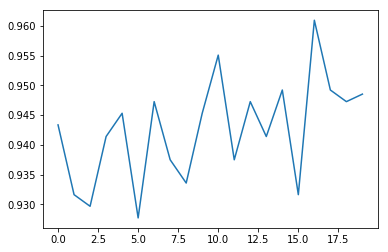

In [28]:
plt.plot(accs)

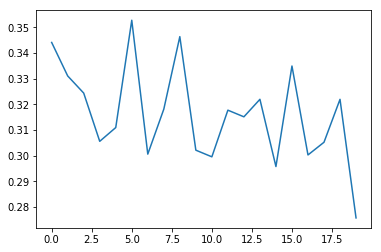

In [29]:
plt.plot(losses)

In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
#import 
from exp.nb_07 import *

In [36]:
x_train, y_train, x_valid, y_valid = get_data()
x_train, x_valid = normalize_to(x_train, x_valid)

train_ds, valid_ds = Dataset(x_train ,y_train), Dataset(x_valid, y_valid)

nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)


In [40]:
mnist_view = view_tfm(1, 28, 28)
Recorder??
cbfs = [
    Recorder,
    partial(AvgStatsCallback, accuracy),        
    partial(BatchTransformXCallback, mnist_view)
]

nfs = [8, 16, 32, 64, 64]

In [41]:
def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2, bias=True),
        GeneralRelu(**kwargs)
    )

In [42]:
learn, run = get_learn_run(nfs, data, 0.6, conv_layer, cbs=cbfs)

In [43]:
# LSUV
# run a batch through and observe vars at each activations
# then rescale weights using observed vars on those activations 
# corresponding to each layers




In [44]:
run.fit(2, learn)

train: [1.69706390625, tensor(0.4177)]
valid: [0.45616328125, tensor(0.8594)]
train: [0.3069393359375, tensor(0.9102)]
valid: [0.1478398681640625, tensor(0.9564)]


In [45]:
learn, run = get_learn_run(nfs, data, 0.6, conv_layer, cbs=cbfs)

In [46]:
#export 
def get_batch(dl, run):
    run.xb, run.yb = next(iter(dl))
    for cb in run.cbs:
        cb.set_runner(run)
    
    run('begin_batch')
    return run.xb, run.yb


In [49]:
xb, yb = get_batch(data.train_dl, run)

In [66]:
#export 

def find_modules(m, cond):
    if cond(m):
        return [m]
    
    res = []    
    for o in m.children():
        lst = find_modules(o, cond)
        if len(lst) > 0:
            res.append(*lst) 
    
    return res    


In [67]:
def is_lin_layer(l):
    lin_layers = (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)
    return isinstance(l, lin_layers)

In [68]:
find_modules(learn.model, is_lin_layer)

[Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Linear(in_features=64, out_features=10, bias=True)]

In [64]:
a = [1]
a.append(*[2])
a


[1, 2]